# Laboratorium 3 - rozwiązanie
## Analiza danych - DataFrames
**Paweł Kruczkiewicz**

### Zadania
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

1. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

1. Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

1. Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

1. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

1. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 


## Zbiór testowy

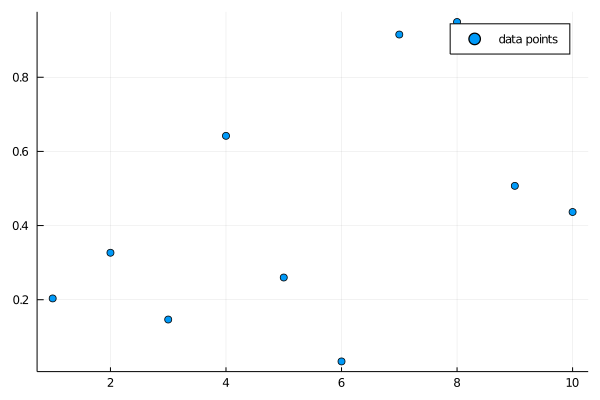

In [1]:
using Plots

xs =  1:1:10
ys = [rand() for x in xs]

xsf=1:0.01:10       #punkty do rysowania wykresów
scatter(xs,ys, label="data points")

# xs = [3.0, 1.0, 5.0, 6.0]
# ys = [1.0, -3.0, 2.0, 4.0]

# xsf = 1:0.01:6
# scatter(xs,ys, label="data points")

## Zad 1

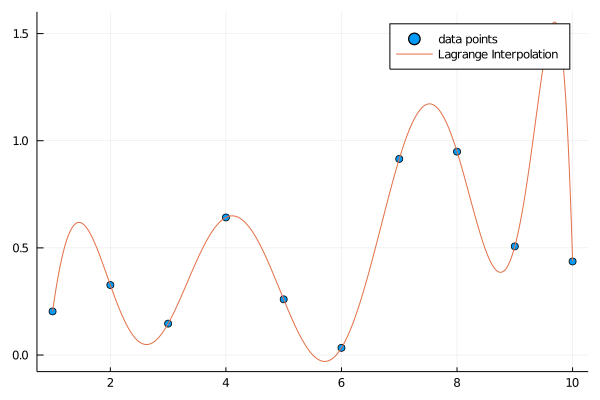

In [4]:
function lagrangeInterpolation(xs, ys)
   function closure(x)
        function L_k(xk)
            d = m = 1
            for xi in xs
                if xi != xk
                    d *= x - xi
                    m *= xk - xi
                end
            end
            return d/m
        end
        result = 0
        n = length(xs)
        for k in 1:n
            result += ys[k]*L_k(xs[k])
        end
        return result
    end     
end

laInterpol = lagrangeInterpolation(xs, ys)

ysf=[laInterpol(x) for x in xsf]
plot!(xsf,ysf, label="Lagrange Interpolation")

BONUS: Już na powyższym przykładzie widać efekt Rungego

## Zad 2
1. Deklarowanie własnego typu

In [5]:
mutable struct newt
    xs      #known x coordinates
    ys      #known y coordinates
    div_diff # table (only values necessary for computing polynomial)
end

2. Stworzenie funkcji obliczającej newd

In [6]:
function NewtonInterpolation(xs, ys)
    result=newt(xs, ys, copy(ys))
    n = length(xs)
    for j in 2:n
        for i in n:-1:j
            result.div_diff[i] = (result.div_diff[i] - result.div_diff[i-1])/(xs[i] - xs[i-j+1])
        end
    end
    return result
end

newt_example = NewtonInterpolation(xs, ys)

newt(1:1:10, [0.2034787416956938, 0.3267024315215217, 0.14658517707180496, 0.641946316814874, 0.25989466205089196, 0.03357728933462423, 0.9151850645040367, 0.9490201859417944, 0.507066335028566, 0.4365908221586454], [0.2034787416956938, 0.12322368982582788, -0.1516704721377723, 0.16313655641138838, -0.10548793863200698, 0.042647906603523085, -0.01081214342832524, 0.001512858191989499, 1.4822304075690193e-5, -6.605640018716991e-5])

3. Obliczanie wartości wielomianu

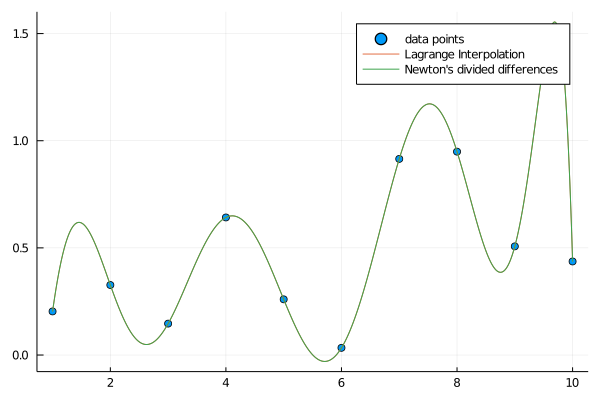

In [7]:
function newt_value(newt_obj, x)
    xs = newt_obj.xs
    d = newt_obj.div_diff
    n = length(d)
    
    result = d[n]
    for i in n-1:-1:1
        result = result*(x-xs[i]) + d[i]
    end
    return result
end

ysf=[newt_value(newt_example, x) for x in xsf]
plot!(xsf,ysf, label="Newton's divided differences")

## Zad 3

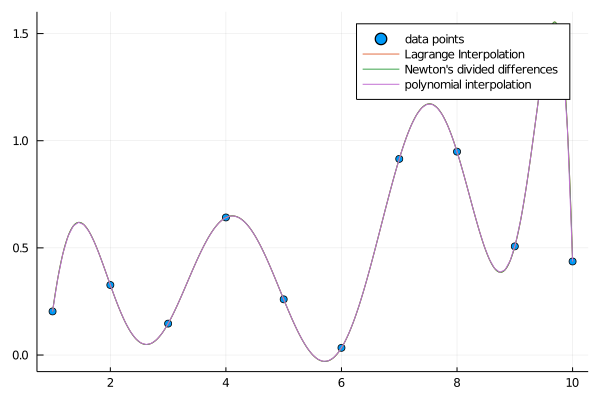

In [8]:
using Polynomials
f=fit(xs, ys)
plot!(f,  extrema(xs)..., label="polynomial interpolation")

Wszystkie interpolacje wielomianowe pokrywają się z prostego powodu: istnieje dokładnie jeden wielomian przechodzący przez zadane n punktów; każdy z algorytmów znajduje właśnie ten wielomian.

## Zad 4 

In [9]:
using DataFrames
using Statistics

In [18]:
function add_to_tables(t1, t2, t3)
    function add_values(val1, val2, val3)
        push!(t1, val1)
        push!(t2, val2)
        push!(t3, val3)
    end
end

xsf = range(0.25, stop=99.75, length=1000)  #constant quantity of points, for which we calculate the polynomials values

n_s = 100:100:500
no_of_points = Int[]
time_measurement = Float64[]
type_of_measurement = Int[]

add_values = add_to_tables(no_of_points, time_measurement, type_of_measurement)
for n in n_s
    print("n=")
    println(n)
    
    for i in 1:10
        print("i=")
        println(i)
        #points
        xs = range(0,stop=100,length=n)
        ys = [rand() for x in xs]
       
        #lagrange 
        time = (@timed interpolFunc = lagrangeInterpolation(xs, ys))[2]
        time += (@timed [interpolFunc(x) for x in xsf])[2]
        add_values(n, time, 1)
        
        #newton - computing polynomial
        time = (@timed newt_tmp = NewtonInterpolation(xs, ys))[2]
        add_values(n, time, 2)
        
        #newton - computing values
        time = (@timed [interpolFunc(x) for x in xsf])[2]
        add_values(n, time, 3)
        
        #polynomials - computing polynomial
        time = (@timed  f=fit(xs, ys))[2]
        add_values(n, time, 4)
        
        #polynomials - computing values
        time = (@timed [f(x) for x in xsf])[2]
        add_values(n, time, 5)
    end
end

df = DataFrame(Rozmiar = no_of_points,
    Czas = time_measurement,
    Typ = type_of_measurement)
show(df)

n=100
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
n=200
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
n=300
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
n=400
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
n=500
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
250×3 DataFrame
 Row │ Rozmiar  Czas         Typ   
     │ Int64    Float64      Int64 
─────┼─────────────────────────────
   1 │     100  0.109231         1
   2 │     100  0.000892299      2
   3 │     100  0.0745261        3
   4 │     100  5.45e-5          4
   5 │     100  0.000145999      5
   6 │     100  0.125868         1
   7 │     100  0.000840101      2
   8 │     100  0.087345         3
   9 │     100  5.5099e-5        4
  10 │     100  0.0001462        5
  11 │     100  0.129597         1
  ⋮  │    ⋮          ⋮         ⋮
 241 │     500  1.7742           1
 242 │     500  0.0192811        2
 243 │     500  1.82426          3
 244 │     500  0.0014211        4
 245 │     500  0.000746001      5
 246 │     500  1.81104          1
 247 │     50

In [19]:
combined_df = combine(groupby(df, [:Typ, :Rozmiar]), :Czas => mean, :Czas => std)

,Typ,Rozmiar,Czas_mean,Czas_std
,Int64,Int64,Float64,Float64
1,1,100,0.11522,0.0225951
2,2,100,0.00242347,0.00458791
3,3,100,0.0822868,0.00842378
4,4,100,6.126e-5,1.3455e-5
5,5,100,0.00017669,5.71262e-5
6,1,200,0.407686,0.0687342
7,2,200,0.00420765,0.00153775
8,3,200,0.350218,0.0728064
9,4,200,0.00027098,9.92556e-5


In [20]:
grouped_dfs = [filter(row -> row[:Typ] == i, combined_df) for i in 1:5]

5-element Array{DataFrame,1}:
 5×4 DataFrame
 Row │ Typ    Rozmiar  Czas_mean  Czas_std  
     │ Int64  Int64    Float64    Float64   
─────┼──────────────────────────────────────
   1 │     1      100   0.11522   0.0225951
   2 │     1      200   0.407686  0.0687342
   3 │     1      300   0.697221  0.042896
   4 │     1      400   1.19779   0.0807324
   5 │     1      500   1.8126    0.0547413
 5×4 DataFrame
 Row │ Typ    Rozmiar  Czas_mean   Czas_std   
     │ Int64  Int64    Float64     Float64    
─────┼────────────────────────────────────────
   1 │     2      100  0.00242347  0.00458791
   2 │     2      200  0.00420765  0.00153775
   3 │     2      300  0.0114852   0.0050477
   4 │     2      400  0.0154062   0.00415714
   5 │     2      500  0.0270408   0.0048735
 5×4 DataFrame
 Row │ Typ    Rozmiar  Czas_mean  Czas_std   
     │ Int64  Int64    Float64    Float64    
─────┼───────────────────────────────────────
   1 │     3      100  0.0822868  0.00842378
   2 │     3      2

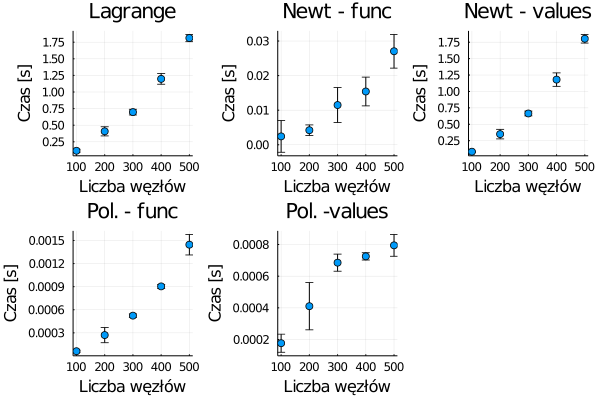

In [21]:
h = [scatter(df.Rozmiar, df.Czas_mean, yerr=df.Czas_std, legend=false) for df in grouped_dfs]

plot(h[1], h[2], h[3], h[4], h[5], layout=5, ylabel = "Czas [s]", xlabel= "Liczba węzłów", title=["Lagrange" "Newt - func" "Newt - values" "Pol. - func" "Pol. -values"])



Zdecydowanie najszybsze okazało się wyliczanie interpolacji poprzez systemowe funkcje. Metoda Lagrange'a osiąga bardzo zbliżone wyniki do metody Newtona, jednak w tej drugiej łatwo jest dodać nowy węzeł interpolacyjny. Warto zauważyć, że algorytm obliczania różnic skończonych znacznie zwiększa niepewność wraz ze wzrostem liczby punktów. Co ważne - algorytmy Newtona i Lagrange'a przyjmują dowolne punkty, natomiast `fit` z pakietu `Polynomials` zakłada równe odległości między punktami

## Zad 5
Algorytm Neville'a

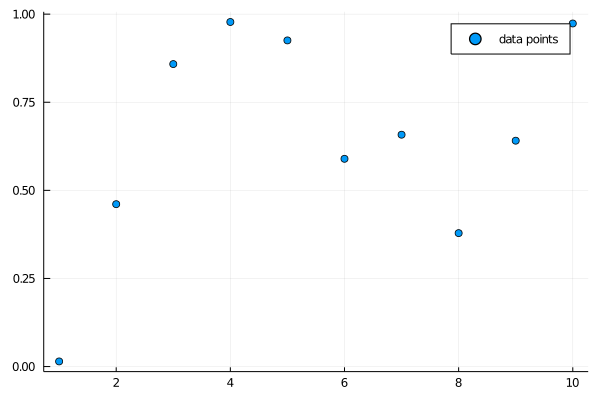

In [30]:
xs = 1:10
ys = ys = [rand() for x in xs]

xsf=1:0.01:10       #punkty do rysowania wykresów
scatter(xs,ys, label="data points")

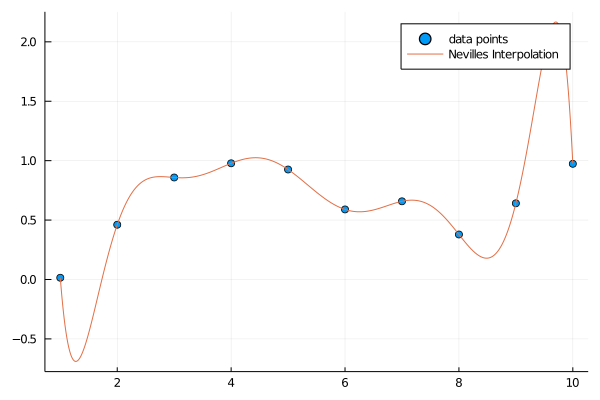

In [31]:
function nevillesInterpolation(xs, ys, x)
    n = length(xs)
    p = copy(ys)
    for k in 2:n
        for i in 1:n-k+1
            d = (x - xs[i+k-1])*p[i] + (xs[i] - x)*p[i+1]
            m = xs[i] - xs[i+k-1]
            p[i] = d/m
        end
    end
    return p[1]
end

ysf=[nevillesInterpolation(xs, ys, x) for x in xsf]
plot!(xsf,ysf, label="Nevilles Interpolation")

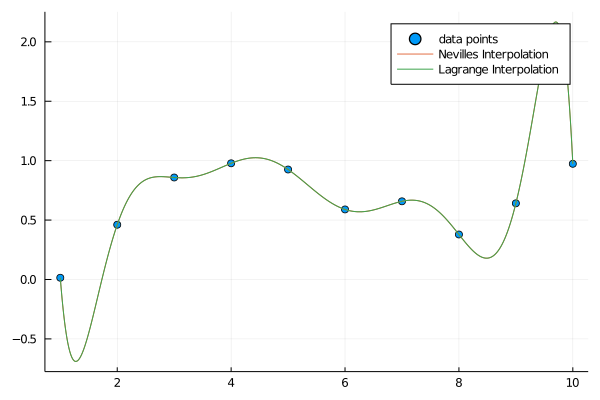

In [32]:
laInterpol = lagrangeInterpolation(xs, ys)
ysf=[laInterpol(x) for x in xsf]
plot!(xsf,ysf, label="Lagrange Interpolation")

Jak widać - wykresy są takie same. Tak miało wyjść.

## Zad 6 
Efekt Rungego

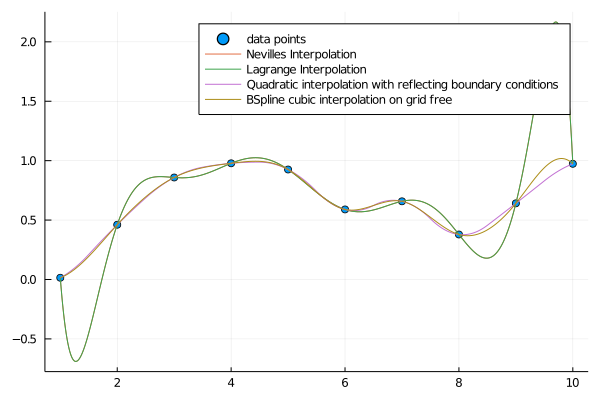

In [33]:
#interpolacja wielomianowa zostaje z poprzednich komórek

using Interpolations
itp = interpolate(ys, BSpline(Quadratic(Reflect(OnCell()))))
ysf3 = [itp(x) for x in xsf]
plot!(xsf,ysf3, label="Quadratic interpolation with reflecting boundary conditions")

itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline cubic interpolation on grid free", legend=:best)

Na powyższym przykładzie efekt Rungego jest bardzo wyraźny - wartość ekstremum funkcji interpolowanej w przedziale (1, 2) wynosi aż -0.7 , podczas gdy interpolacja funkcjami B-sklejanymi stopnia 3 i 4 osiąga maksimum jedynie w wejściowych punktach. Podobną sytuację widzimy na prawym końcu przedziału, gdzie interpolacja wielomianowa ma wartość maksymalną 2.